In [3]:
import os
import random

import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import torchvision.transforms.functional as F
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader

In [4]:
import torch
import torch.nn as nn

class Dehazer(nn.Module):
    def __init__(self, in_channels=3, out_channels=3):
        super(Dehazer, self).__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        self.decoder = nn.Sequential(
            nn.Conv2d(512, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
            nn.Conv2d(256, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
            nn.Conv2d(64, out_channels, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )
            
#         self.decoder = nn.Sequential(
#             nn.Conv2d(512, 256, kernel_size=3, stride=1, padding=1),
#             nn.ReLU(inplace=True),
#             nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
#             nn.ReLU(inplace=True),
#             nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
#             nn.ReLU(inplace=True),
#             nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
#             nn.ReLU(inplace=True),
#             nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
#             nn.ReLU(inplace=True),
#             nn.ConvTranspose2d(64, out_channels, kernel_size=4, stride=2, padding=1),
#             nn.ReLU(inplace=True),
#         )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [5]:
class PerceptualLoss(nn.Module):
    def __init__(self, net, gamma=0.0):
        super(PerceptualLoss, self).__init__()
        self.net = net
        self.gamma = gamma
        self.net.eval()
        
    def forward(self, output, target):
        # Extract features from the VGG16 model for output and target
        output_features = self.net(output)
        target_features = self.net(target)

        # Compute the L2 distance between the features
        perceptual_loss = nn.MSELoss()(output_features, target_features)
        
        # pixel wise loss
        pixel_loss = nn.MSELoss()(output, target)
        
#         return pixel_loss
        return perceptual_loss + self.gamma * pixel_loss

In [6]:
class OHaze(Dataset):
    def __init__(self, data_dir, transform=None):
        
        self.data_dir = data_dir
        self.transform = transform[0]
        self.target_transform = transform[1]
        self.x = []
        self.y = []
        
        files = []
        for f in os.listdir(data_dir):
            files.append(f)
        
        for f in files:
            if not f.startswith("_groundtruth_"):
                sample = os.path.join(data_dir, f)
                gt = os.path.join(data_dir, f"_groundtruth_(1)_{f}").replace("_original", "")
                assert os.path.isfile(sample), sample
                assert os.path.isfile(gt), gt
                
                self.x.append(sample)
                self.y.append(gt)
        
    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        image = np.array(Image.open(self.x[idx]))/255
        target = np.array(Image.open(self.y[idx]))/255
        
        if self.transform is not None:
            image = self.transform(image.astype("float32"))
        if self.target_transform is not None:
            target = self.target_transform(target.astype("float32"))
        
        return image, target

class OHazeTest(Dataset):
    def __init__(self, data_dir, transform):
        
        self.data_dir = data_dir
        self.transform = transform[0]
        self.target_transform = transform[1]
        self.x = []
        self.y = []

        for f in sorted(os.listdir(os.path.join(data_dir, "hazy"))):
            sample = os.path.join(data_dir, "hazy", f)
            assert os.path.isfile(sample), sample
            self.x.append(sample)
        
        for f in sorted(os.listdir(os.path.join(data_dir, "GT"))):
            sample = os.path.join(data_dir, "GT", f)
            assert os.path.isfile(sample), sample
            self.y.append(sample)
        
    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        image = np.array(Image.open(self.x[idx]))/255
        target = np.array(Image.open(self.y[idx]))/255
        
        if self.transform is not None:
            image = self.transform(image.astype("float32"))
        
        if self.target_transform is not None:
            target = self.target_transform(target.astype("float32"))
        
        return image, target    

In [14]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.CenterCrop(400),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])          
])

target_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.CenterCrop(400),
])

train_dataset = OHaze("ohaze/train/hazy/output", transform=[transform, target_transform])
test_dataset = OHazeTest("ohaze/test", transform=[transform, target_transform])

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=4, persistent_workers=True)
test_loader = DataLoader(test_dataset, batch_size=8,  shuffle=False)

In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [16]:
model = Dehazer()
num_params_m = sum(torch.numel(p) for p in model.parameters())
print(f"Number of parameters in the model: {num_params_m}")

# VGG for perceptual loss
vgg_model = models.vgg16(pretrained=True).features
feat_extractor = nn.Sequential(*list(vgg_model.children())[:24])  # from relu4_2 layer
feat_extractor.add_module("avgpool",nn.AdaptiveAvgPool2d((1, 1)))

# ResNet for perceptual loss
# resnet = models.resnet18(pretrained=True)
# feat_extractor = nn.Sequential(*list(resnet.children())[:7])
# feat_extractor.add_module("avgpool",nn.AdaptiveAvgPool2d((1, 1)))

num_params_f = sum(torch.numel(p) for p in feat_extractor.parameters())
print(f"Number of parameters in the feature extractor: {num_params_f}")

# Loss
feat_extractor.to(device)
criterion = PerceptualLoss(feat_extractor, gamma=1.35)

Number of parameters in the model: 3474057
Number of parameters in the feature extractor: 7635264


In [17]:
# print(feat_extractor)

In [18]:
learning_rate = 1e-3
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [19]:
model.to(device)

num_epochs = 15
for epoch in range(num_epochs):
    
        running_loss = 0.0
        for images, targets in train_loader:
            images = images.to(device)
            targets = targets.to(device)

            # Forward pass
            outputs = model(images)

            # Compute the loss
            loss = criterion(outputs, targets)

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        epoch_loss = running_loss / len(train_loader)
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.6f}")


Epoch [1/15], Loss: 0.165227
Epoch [2/15], Loss: 0.120933
Epoch [3/15], Loss: 0.100379
Epoch [4/15], Loss: 0.081615
Epoch [5/15], Loss: 0.074178
Epoch [6/15], Loss: 0.067228
Epoch [7/15], Loss: 0.061742
Epoch [8/15], Loss: 0.054595
Epoch [9/15], Loss: 0.051016
Epoch [10/15], Loss: 0.047045
Epoch [11/15], Loss: 0.045868
Epoch [12/15], Loss: 0.044520
Epoch [13/15], Loss: 0.044944
Epoch [14/15], Loss: 0.041432
Epoch [15/15], Loss: 0.038689


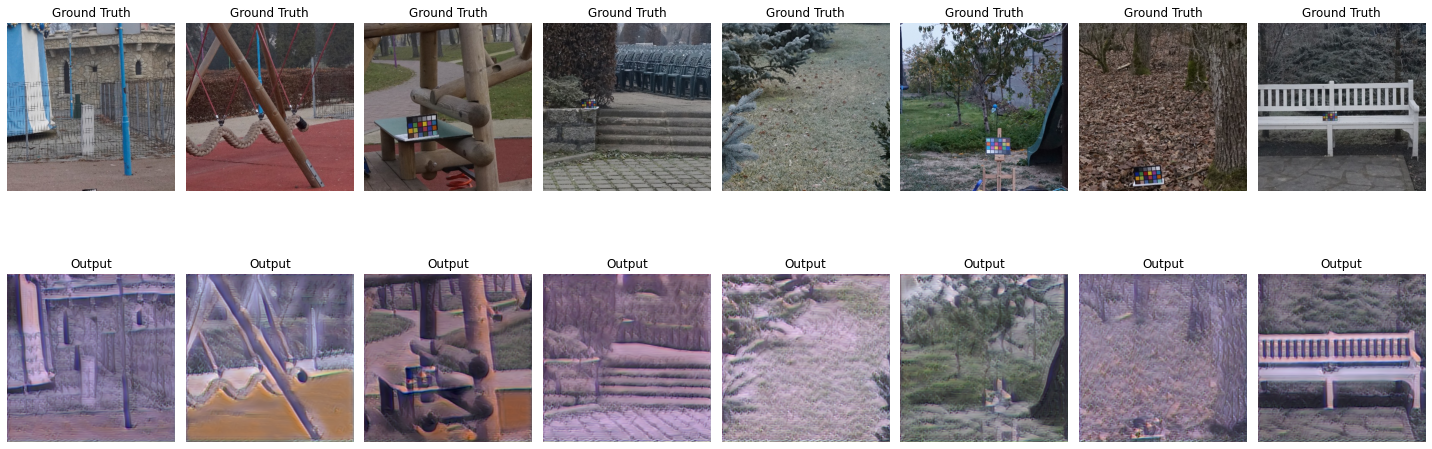

In [20]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

with torch.no_grad():
    for images, targets in test_loader:
        images = images.to(device)

        # Forward pass
        outputs = model(images)

        # Convert the outputs and targets to numpy arrays
        outputs_np = outputs.cpu().numpy()
        targets_np = targets.numpy()

        
        batch_size = outputs.shape[0]
    
        fig, axs = plt.subplots(2, batch_size, figsize=(20, 8))
        
        for i in range(batch_size):
            
#             fig, axs = plt.subplots(1, 2)
            
            # get channel-wise max
            maxes = []
            for c in range(3):
                maxes.append(outputs_np[i][c].max())
            maxes = np.array(maxes)

            # normalize using max values
            for c in range(3):
                outputs_np[i][c] /= maxes[c]
            outputs_np[i] *= 255

            output = outputs_np[i].astype("uint8")
            
            # Plot ground truth image in the first row
            axs[0, i].imshow(targets_np[i].transpose(1, 2, 0))
            axs[0, i].set_title("Ground Truth")
            axs[0, i].axis("off")

            # Plot predicted image in the second row
            axs[1, i].imshow((output).transpose(1, 2, 0))
            axs[1, i].set_title("Output")
            axs[1, i].axis("off")

#             axs[0].imshow((output).transpose(1, 2, 0))
#             axs[0].set_title("Output")
#             axs[0].axis("off")

#             axs[1].imshow(targets_np[i].transpose(1, 2, 0))
#             axs[1].set_title("Ground Truth")
#             axs[1].axis("off")

#             plt.show()

        plt.tight_layout()
        plt.show()
        
        break
